In [1]:
import os, sys
import numpy as np
import pandas as pd

In [2]:
sys.path.insert(0, '/home/jgutman/mvesc/ETL')

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from mvesc_utility_functions import *

In [71]:
from collections import OrderedDict

In [84]:
descriptives = '/home/jgutman/mvesc/Descriptives'

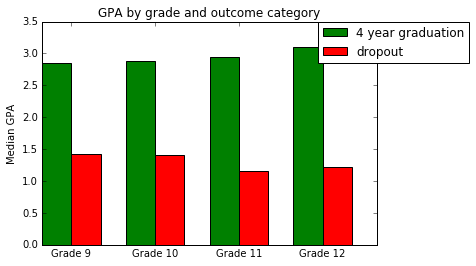

In [99]:
with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        columns = ['gpa']
        grades = range(9, 13)
        source_table = 'grades'
        outcome_nicknames = OrderedDict([('graduates', '4 year graduation'),
                            ('hasIRN', 'dropout')])
        
        # create temporary tables to compare features for the two buckets of interest
        for nickname, outcome in outcome_nicknames.items():
            create_gpa_bucket = create_table_query(columns, grades, nickname, outcome, source_table)
            cursor.execute(create_gpa_bucket)
        
        # now run query to get the median value of each feature by bucket
        median_comparison_query = create_median_query(columns, grades, outcome_nicknames.keys())
        cursor.execute(median_comparison_query)
        
        # store the results in a pandas dataframe
        comparison = cursor.fetchall()
        colnames = [i[0] for i in cursor.description]
        median_gpa_comparison = pd.DataFrame.from_records(comparison, index = 'label', columns = colnames)
        
        # plot the results in side by side bar chart
        filename = ('compare_' + columns[0] + '_' + '_'.join(outcome_nicknames.keys()))
        plot_comparisons(median_gpa_comparison, grades, os.path.join(descriptives, filename), 
                         [k for k in outcome_nicknames.keys()], [v for v in outcome_nicknames.values()], 
                         outcome_colors = ['g', 'r'], ylabel = 'Median GPA', 
                         title = 'GPA by grade and outcome category')

In [15]:
def create_table_query(columns, grades, nickname, outcome, source_table):
    column_list = ["{}_gr_{}".format(col, gr) for col in columns for gr in grades]
    temp_table = "_".join(columns + [nickname])
    column_list_formatted = ", ".join(column_list)
    
    query_subset_feature_by_bucket = """
    create temporary table {temp_table} as
    (select {column_list_formatted}
    from model.{source_table}
    where student_lookup in
    (select student_lookup from clean.wrk_tracking_students
    where outcome_bucket = '{outcome}'));
    """.format(temp_table = temp_table, column_list_formatted = column_list_formatted, 
              source_table = source_table, outcome = outcome)
    return query_subset_feature_by_bucket

In [17]:
def create_median_query(columns, grades, nicknames):
    column_list = ["{}_gr_{}".format(col, gr) for col in columns for gr in grades]
    temp_tables = ["_".join(columns + [nickname]) for nickname in nicknames]
    
    compare_medians_across_subgroups = []
    for nickname, table in zip(nicknames, temp_tables):
        get_median_all_grades = ["""
        percentile_cont(.50) within group (order by {column}) as median_{column}""".format(
                column = column) for column in column_list]
        get_median_formatted = ", ".join(get_median_all_grades)
        get_median_subgroup_query = """select '{nickname}' as label, {get_median_formatted}
        from {table}""".format(nickname = nickname, 
                                get_median_formatted = get_median_formatted, table = table)
        compare_medians_across_subgroups.append(get_median_subgroup_query)
    comparison_query = """
    union
    """.join(compare_medians_across_subgroups)
    return comparison_query

In [27]:
median_comparison

,median_gpa_gr_9,median_gpa_gr_10,median_gpa_gr_11,median_gpa_gr_12
label,,,,
graduates,2.843125,2.880682,2.951667,3.100000
noIRN,1.958974,2.022424,1.853333,1.678545


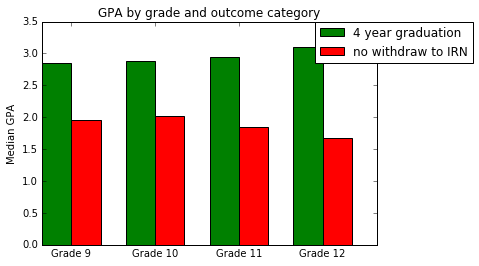

In [56]:
N = median_comparison.shape[1]
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
plot_graduates = ax.bar(ind, median_comparison.loc['graduates'], width, color='g')
plot_noIRN = ax.bar(ind+width, median_comparison.loc['noIRN'], width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Median GPA')
ax.set_title('GPA by grade and outcome category')
ax.set_xticks(ind + width)
ax.set_xticklabels(['Grade '+ str(gr) for gr in grades])
ax.legend((plot_graduates[0], plot_noIRN[0]), 
          (outcome_nicknames['graduates'], outcome_nicknames['noIRN']), 
         bbox_to_anchor=(1.05, 1), loc=9, borderaxespad=0.) # positions the legend just outside the figure

plt.show()

In [82]:
def plot_comparisons(comparison_df, grades, filename,
                         outcome_nicknames, outcome_labels, outcome_colors, 
                         ylabel, title):
    N = comparison_df.shape[1]
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig, ax = plt.subplots()
    plot_reference_group = ax.bar(ind, comparison_df.loc[outcome_nicknames[0]], 
                                  width, color = outcome_colors[0])
    plot_comparison_group = ax.bar(ind + width, comparison_df.loc[outcome_nicknames[1]], 
                                   width, color = outcome_colors[1])

    # add some text for labels, title and axes ticks
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(ind + width)
    ax.set_xticklabels(['Grade '+ str(gr) for gr in grades])
    
    ax.legend((plot_reference_group[0], plot_comparison_group[0]), 
              (outcome_labels[0], outcome_labels[1]), 
             bbox_to_anchor=(1.05, 1), loc=9, borderaxespad=0.) # positions the legend just outside the figure

    plt.savefig(filename, bbox_inches='tight')
    plt.show()

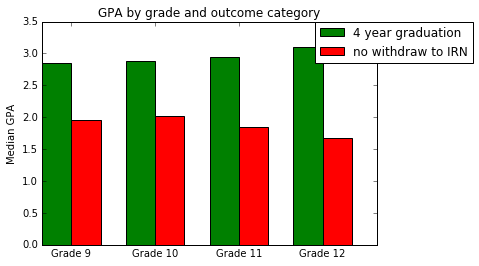

In [83]:
plot_comparisons(median_gpa_comparison, grades, '/home/jgutman/mvesc/Descriptives/test_barplot.png',
                         [k for k in outcome_nicknames.keys()], [v for v in outcome_nicknames.values()], 
                         outcome_colors = ['g', 'r'], ylabel = 'Median GPA', 
                         title = 'GPA by grade and outcome category')

In [85]:
'_'.join(outcome_nicknames.keys())

'graduates_noIRN'

In [87]:
filename = os.path.join(descriptives, )

SyntaxError: unexpected EOF while parsing (<ipython-input-87-d425aa431a13>, line 1)

In [92]:
('compare_' + columns[0] + '_' + '_'.join(outcome_nicknames.keys()))

'compare_gpa_graduates_noIRN'

In [89]:
columns[0]

'gpa'

In [91]:
'_'.join(outcome_nicknames.keys())

'graduates_noIRN'

In [97]:
median_mobility_comparison

,median_n_addresses_to_gr_8,median_n_addresses_to_gr_9,median_n_addresses_to_gr_10,median_n_addresses_to_gr_11,median_n_addresses_to_gr_12,median_n_districts_to_gr_8,median_n_districts_to_gr_9,median_n_districts_to_gr_10,median_n_districts_to_gr_11,median_n_districts_to_gr_12
label,,,,,,,,,,
graduates,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
noIRN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
